Epoch 1/10: 100%|██████████| 32/32 [00:01<00:00, 16.28it/s]


Epoch 1, Loss: 19.5232


Epoch 2/10: 100%|██████████| 32/32 [00:00<00:00, 93.94it/s]


Epoch 2, Loss: 70.9515


Epoch 3/10: 100%|██████████| 32/32 [00:00<00:00, 95.72it/s]


Epoch 3, Loss: 0.7152


Epoch 4/10: 100%|██████████| 32/32 [00:00<00:00, 95.17it/s]


Epoch 4, Loss: 0.9112


Epoch 5/10: 100%|██████████| 32/32 [00:00<00:00, 94.30it/s]


Epoch 5, Loss: 0.9959


Epoch 6/10: 100%|██████████| 32/32 [00:00<00:00, 95.19it/s]


Epoch 6, Loss: 2.9179


Epoch 7/10: 100%|██████████| 32/32 [00:00<00:00, 96.62it/s]


Epoch 7, Loss: 7.1392


Epoch 8/10: 100%|██████████| 32/32 [00:00<00:00, 95.34it/s]


Epoch 8, Loss: 46.0818


Epoch 9/10: 100%|██████████| 32/32 [00:00<00:00, 95.66it/s]


Epoch 9, Loss: 169.2304


Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 94.70it/s]


Epoch 10, Loss: 220.0068


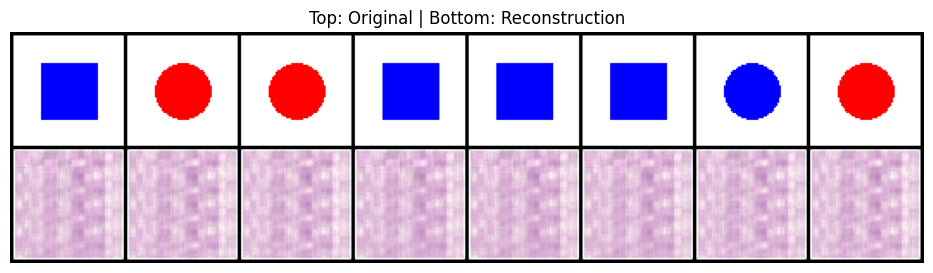

In [2]:
# Mini DALL·E Style Text-to-Image in PyTorch (Educational Version)
# Part 1: VQ-VAE (Train to encode/decode simple geometric images)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from tqdm import tqdm
from PIL import Image, ImageDraw

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate toy dataset: shapes with captions
class ShapesDataset(Dataset):
    def __init__(self, n=1000, size=64):
        self.data = []
        self.labels = []
        self.size = size
        self.shapes = ['circle', 'square']
        self.colors = ['red', 'blue']
        self.transform = T.Compose([
            T.ToTensor(),
        ])
        for _ in range(n):
            shape = random.choice(self.shapes)
            color = random.choice(self.colors)
            img = self.generate_image(shape, color)
            caption = f"{color} {shape}"
            self.data.append(img)
            self.labels.append(caption)

    def generate_image(self, shape, color):
        img = Image.new('RGB', (self.size, self.size), 'white')
        draw = ImageDraw.Draw(img)
        fill = color
        if shape == 'circle':
            draw.ellipse((16, 16, 48, 48), fill=fill)
        elif shape == 'square':
            draw.rectangle((16, 16, 48, 48), fill=fill)
        return img

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx]), self.labels[idx]

# Create dataset
dataset = ShapesDataset(n=1000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# VQ-VAE components
class VectorQuantizer(nn.Module):
    def __init__(self, n_e=64, e_dim=64, beta=0.25):
        super().__init__()
        self.e_dim = e_dim
        self.n_e = n_e
        self.beta = beta
        self.embedding = nn.Embedding(n_e, e_dim)
        self.embedding.weight.data.uniform_(-1/n_e, 1/n_e)

    def forward(self, z):
        z_flattened = z.permute(0, 2, 3, 1).reshape(-1, self.e_dim)
        dist = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
               torch.sum(self.embedding.weight ** 2, dim=1) - \
               2 * torch.matmul(z_flattened, self.embedding.weight.t())
        encoding_indices = torch.argmin(dist, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.n_e, device=z.device)
        encodings.scatter_(1, encoding_indices, 1)
        quantized = torch.matmul(encodings, self.embedding.weight).view(z.shape)
        commitment_loss = self.beta * F.mse_loss(quantized.detach(), z)
        quantized = z + (quantized - z).detach()
        return quantized, commitment_loss, encoding_indices.view(z.shape[0], z.shape[2], z.shape[3])

class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 1)
        )
        self.vq = VectorQuantizer(n_e=64, e_dim=64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 1)
        )

    def forward(self, x):
        z = self.encoder(x)
        quant, vq_loss, indices = self.vq(z)
        recon = self.decoder(quant)
        return recon, vq_loss

# Train VQ-VAE
model = VQVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for x, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/10"):
        x = x.to(device)
        recon, vq_loss = model(x)
        recon_loss = F.mse_loss(recon, x)
        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

# Visualize reconstructions
def show_recon(model, dataset):
    model.eval()
    x, _ = next(iter(DataLoader(dataset, batch_size=8)))
    with torch.no_grad():
        x = x.to(device)
        recon, _ = model(x)
    both = torch.cat([x.cpu(), recon.cpu()], dim=0)
    grid = make_grid(both, nrow=8)
    plt.figure(figsize=(12, 3))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Top: Original | Bottom: Reconstruction")
    plt.axis('off')
    plt.show()

show_recon(model, dataset)
